1) Для выбранного распределения сгенерируйте выборки разного объема и проиллюстрируйте сходимость выборочного среднего к математическому ожиданию (покажите наглядно стабилизацию выборочного среднего)

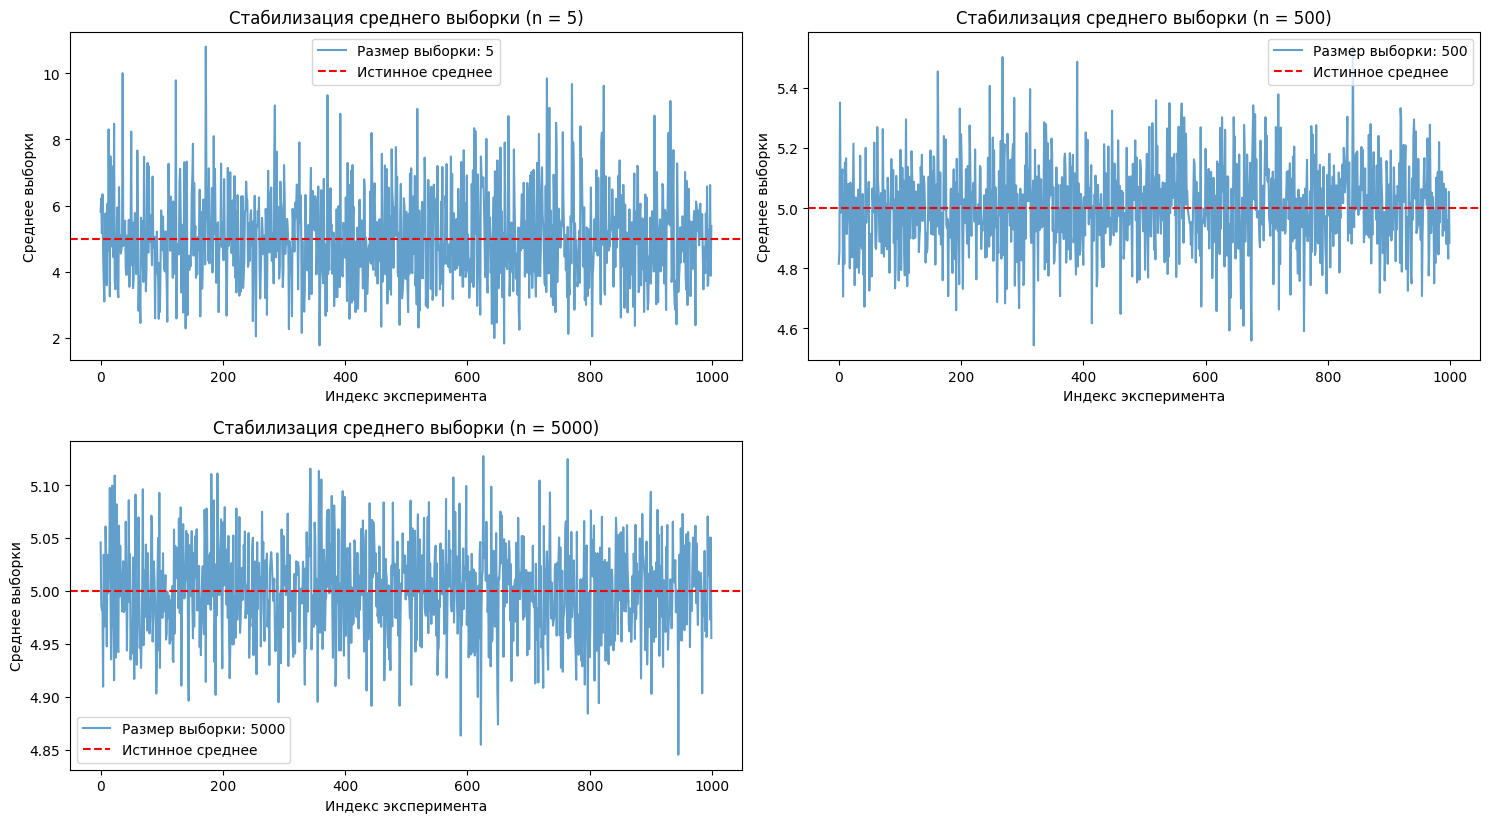

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2, norm, t, mode

df = 5
true_mean = 5
sample_sizes = [5, 500, 5000]
num_experiments = 1000 
means_over_experiments = []

for sample_size in sample_sizes:
    means = [] 
    for _ in range(num_experiments):
        sample = chi2.rvs(df, size=sample_size) 
        means.append(np.mean(sample))
    means_over_experiments.append(np.array(means))

plt.figure(figsize=(15, 12))
for i, sample_size in enumerate(sample_sizes):
    plt.subplot(3, 2, i + 1) 
    plt.plot(means_over_experiments[i], label=f"Размер выборки: {sample_size}", alpha=0.7)
    plt.axhline(y=true_mean, color='r', linestyle='--', label='Истинное среднее')
    plt.xlabel('Индекс эксперимента')
    plt.ylabel('Среднее выборки')
    plt.title(f'Стабилизация среднего выборки (n = {sample_size})')
    plt.legend()

plt.tight_layout()
plt.show()


Большие выборки демонстрируют стабильность, в то время как маленькие наоборот дают не стабильные результаты, из этого следует, что Закон больших чисел действительно работает

2) Наглядно продемонстрируйте центральную предельную теорему в действии для выбранного вами распределения (покажите сходимость с ростом выборки к нормальному распределению).

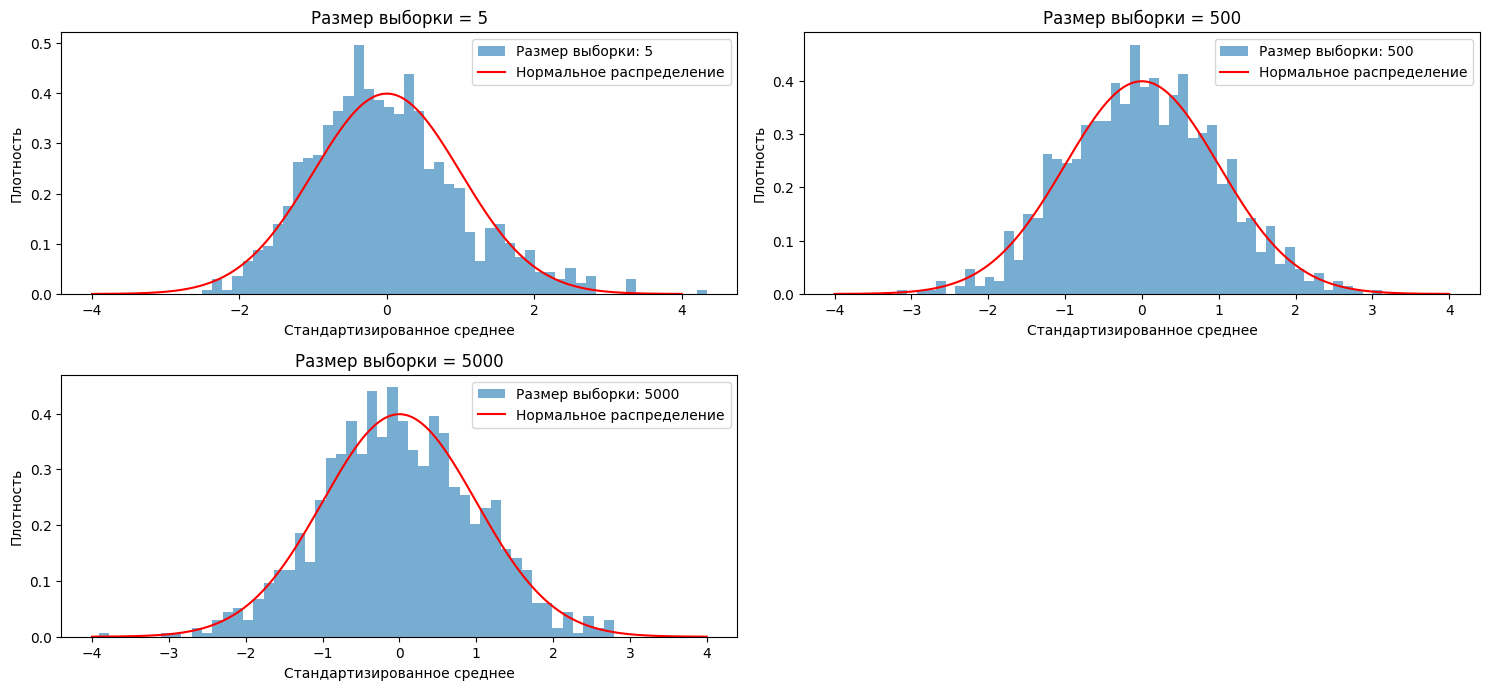

In [8]:
true_std = np.sqrt(2 * df)

plt.figure(figsize=(15, 10))
for i, sample_size in enumerate(sample_sizes):
    samples = np.array([np.mean(chi2.rvs(df, size=sample_size)) for _ in range(num_experiments)])
    standardized_samples = (samples - true_mean) / (true_std / np.sqrt(sample_size))
    plt.subplot(3, 2, i + 1)
    plt.hist(standardized_samples, bins=50, density=True, alpha=0.6, label=f"Размер выборки: {sample_size}")
    x = np.linspace(-4, 4, 1000)
    plt.plot(x, norm.pdf(x, 0, 1), 'r', label="Нормальное распределение")   
    plt.title(f"Размер выборки = {sample_size}")
    plt.xlabel("Стандартизированное среднее")
    plt.ylabel("Плотность")
    plt.legend()

plt.tight_layout()
plt.show()


Центральная предельная теорема наглядно демонстрирует, что с увеличением размера выборки стандартизированные выборочные средние для несимметричного распределения (хи-квадрат) сходятся к стандартному нормальному распределению.

3) асимптотический доверительный интервал для среднего значения на базе ЦПТ

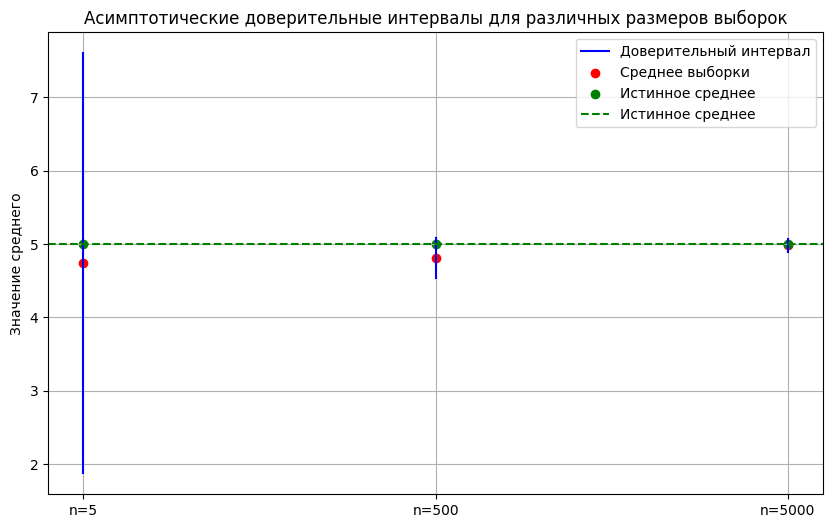

In [9]:
confidence_level = 0.95
z_score = norm.ppf(1 - (1 - confidence_level) / 2)
intervals = []
sample_means = []

for sample_size in sample_sizes:
    sample = chi2.rvs(df, size=sample_size)
    sample_mean = np.mean(sample)
    sample_std = np.std(sample, ddof=1)
    margin_of_error = z_score * (sample_std / np.sqrt(sample_size))
    lower_bound = sample_mean - margin_of_error
    upper_bound = sample_mean + margin_of_error
    intervals.append((lower_bound, upper_bound))
    sample_means.append(sample_mean)

plt.figure(figsize=(10, 6))
for i, sample_size in enumerate(sample_sizes):
    lower, upper = intervals[i]
    mean = sample_means[i]
    plt.plot([i, i], [lower, upper], color='blue', label='Доверительный интервал' if i == 0 else "")
    plt.scatter(i, mean, color='red', label='Среднее выборки' if i == 0 else "")
    plt.scatter(i, true_mean, color='green', label='Истинное среднее' if i == 0 else "")

plt.xticks(range(len(sample_sizes)), labels=[f"n={n}" for n in sample_sizes])
plt.axhline(true_mean, color='green', linestyle='--', label='Истинное среднее')
plt.title('Асимптотические доверительные интервалы для различных размеров выборок')
plt.ylabel('Значение среднего')
plt.legend()
plt.grid()
plt.show()

Асимптотические интервалы для больших выборок обычно будут точнее и уже, так как они основываются на нормальном распределении.

4) точный доверительный интервал для среднего значения (на базе t-критического значения)

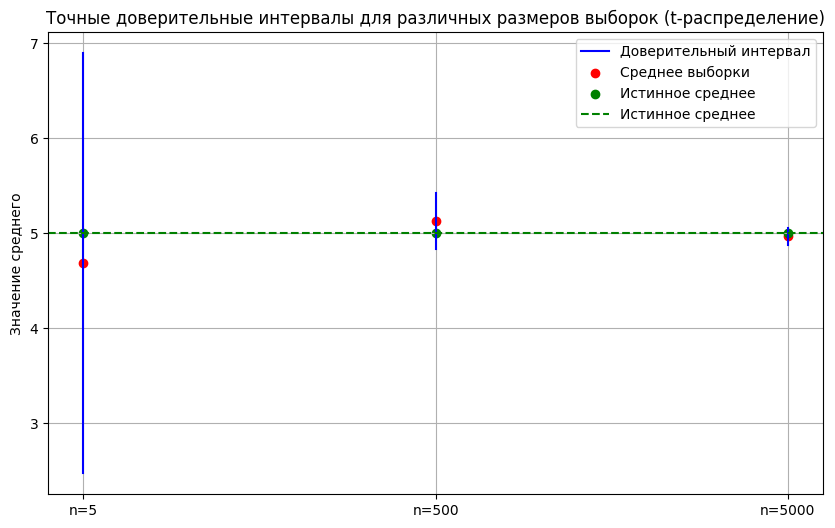

In [10]:
intervals = []
sample_means = []
for sample_size in sample_sizes:
    sample = chi2.rvs(df, size=sample_size)
    sample_mean = np.mean(sample)
    sample_std = np.std(sample, ddof=1) 
    t_score = t.ppf(1 - (1 - confidence_level) / 2, df=sample_size - 1)
    margin_of_error = t_score * (sample_std / np.sqrt(sample_size))
    lower_bound = sample_mean - margin_of_error
    upper_bound = sample_mean + margin_of_error
    intervals.append((lower_bound, upper_bound))
    sample_means.append(sample_mean)

plt.figure(figsize=(10, 6))
for i, sample_size in enumerate(sample_sizes):
    lower, upper = intervals[i]
    mean = sample_means[i]
    plt.plot([i, i], [lower, upper], color='blue', label='Доверительный интервал' if i == 0 else "")
    plt.scatter(i, mean, color='red', label='Среднее выборки' if i == 0 else "")
    plt.scatter(i, true_mean, color='green', label='Истинное среднее' if i == 0 else "")

plt.xticks(range(len(sample_sizes)), labels=[f"n={n}" for n in sample_sizes])
plt.axhline(true_mean, color='green', linestyle='--', label='Истинное среднее')
plt.title('Точные доверительные интервалы для различных размеров выборок (t-распределение)')
plt.ylabel('Значение среднего')
plt.legend()
plt.grid()
plt.show()



Точные интервалы (t-критический метод) могут быть более широкими для малых выборок из-за более широкого распределения t.

5) эфронов доверительный интервал для среднего, медианы, моды, дисперсии.

In [22]:
num_bootstrap = 1000

def bootstrap_stat(data, stat_func, num_resamples):
    resampled_stats = []
    for _ in range(num_resamples):
        resample = np.random.choice(data, size=len(data), replace=True)
        resampled_stats.append(stat_func(resample))
    return np.array(resampled_stats)

def calculate_mode(data):
    counts = np.bincount(np.round(data).astype(int))
    most_common = np.argmax(counts)
    return most_common

statistiki = {
    "Среднее": np.mean,
    "Медиана": np.median,
    "Мода": calculate_mode,
    "Дисперсия": lambda x: np.var(x, ddof=1)
}

rezultaty = {}

for size_vyboriki in sample_sizes:
    sample = chi2.rvs(df, size=size_vyboriki)
    intervals = {}
    for stat_name, stat_func in statistiki.items():
        bootstrap_dist = bootstrap_stat(sample, stat_func, num_bootstrap)
        lower_bound = np.percentile(bootstrap_dist, (1 - confidence_level) / 2 * 100)
        upper_bound = np.percentile(bootstrap_dist, (1 + confidence_level) / 2 * 100)
        intervals[stat_name] = (lower_bound, upper_bound)
    rezultaty[size_vyboriki] = intervals

for size_vyboriki, intervals in rezultaty.items():
    print(f"\nРазмер выборки: {size_vyboriki}")
    for stat_name, (lower, upper) in intervals.items():
        print(f"  {stat_name} Доверительный интервал ({confidence_level * 100:.1f}%): [{lower:.4f}, {upper:.4f}]")



Размер выборки: 5
  Среднее Доверительный интервал (95.0%): [3.0804, 5.6781]
  Медиана Доверительный интервал (95.0%): [2.3069, 5.9206]
  Мода Доверительный интервал (95.0%): [2.0000, 6.0000]
  Дисперсия Доверительный интервал (95.0%): [0.0375, 3.6424]

Размер выборки: 500
  Среднее Доверительный интервал (95.0%): [4.5965, 5.1455]
  Медиана Доверительный интервал (95.0%): [3.9572, 4.6924]
  Мода Доверительный интервал (95.0%): [2.0000, 5.0000]
  Дисперсия Доверительный интервал (95.0%): [7.8398, 11.3185]

Размер выборки: 5000
  Среднее Доверительный интервал (95.0%): [4.8353, 5.0140]
  Медиана Доверительный интервал (95.0%): [4.1498, 4.3409]
  Мода Доверительный интервал (95.0%): [3.0000, 4.0000]
  Дисперсия Доверительный интервал (95.0%): [9.2816, 10.4954]


Бутстрэп-интервалы показывают вариацию между выборками и могут быть более широкими для малых выборок, так как они зависят от повторных выборок.

Тут я провел все три эксперемента в купе, чтобы показать датафрейм, который получился, я использовал во всех эксперементах распределение хи-квадрат с 5 степенями свободы, и генерировал выборки разного объема (5, 500, 5000)

In [21]:
import numpy as np
import pandas as pd
from scipy.stats import chi2, norm, t

df = 5
true_mean = 5
confidence_level = 0.95
z_score = norm.ppf(1 - (1 - confidence_level) / 2)
num_bootstrap = 1000
sample_sizes = [5, 500, 5000]
num_experiments = 1000

def bootstrap_stat(data, stat_func, num_resamples):
    resampled_stats = []
    for _ in range(num_resamples):
        resample = np.random.choice(data, size=len(data), replace=True)
        resampled_stats.append(stat_func(resample))
    return np.array(resampled_stats)

def calculate_mode(data):
    counts = np.bincount(np.round(data).astype(int))
    most_common = np.argmax(counts)
    return most_common

statistic_functions = {
    "Среднее": np.mean,
    "Медиана": np.median,
    "Мода": calculate_mode,
    "Дисперсия": lambda x: np.var(x, ddof=1)
}

results = {}

for sample_size in sample_sizes:
    sample = chi2.rvs(df, size=sample_size)
    sample_mean = np.mean(sample)
    sample_std = np.std(sample, ddof=1)
    
    margin_of_error = z_score * (sample_std / np.sqrt(sample_size))
    asymp_lower = sample_mean - margin_of_error
    asymp_upper = sample_mean + margin_of_error
    
    t_score = t.ppf(1 - (1 - confidence_level) / 2, df=sample_size - 1)
    margin_of_error_t = t_score * (sample_std / np.sqrt(sample_size))
    t_lower = sample_mean - margin_of_error_t
    t_upper = sample_mean + margin_of_error_t
    
    bootstrap_intervals = {}
    for stat_name, stat_func in statistic_functions.items():
        bootstrap_dist = bootstrap_stat(sample, stat_func, num_bootstrap)
        lower_bound = np.percentile(bootstrap_dist, (1 - confidence_level) / 2 * 100)
        upper_bound = np.percentile(bootstrap_dist, (1 + confidence_level) / 2 * 100)
        bootstrap_intervals[stat_name] = (lower_bound, upper_bound)
    
    results[sample_size] = {
        "Асимптотический ДИ": (asymp_lower, asymp_upper),
        "Точный ДИ": (t_lower, t_upper),
        "Бутстрэп ДИ": bootstrap_intervals
    }

df_results = []

for sample_size, res in results.items():
    for method, ci_values in res.items():
        if method == "Бутстрэп ДИ":
            for stat_name, (lower, upper) in ci_values.items():
                df_results.append({
                    "Размер выборки": sample_size,
                    "Метод": method,
                    "Статистика": stat_name,
                    "Нижняя граница": lower,
                    "Верхняя граница": upper,
                    "Ширина": upper - lower
                })
        else:
            df_results.append({
                "Размер выборки": sample_size,
                "Метод": method,
                "Статистика": "Среднее",
                "Нижняя граница": ci_values[0],
                "Верхняя граница": ci_values[1],
                "Ширина": ci_values[1] - ci_values[0]
            })

final_df = pd.DataFrame(df_results)
print(final_df)


    Размер выборки               Метод Статистика  Нижняя граница  \
0                5  Асимптотический ДИ    Среднее        2.331946   
1                5           Точный ДИ    Среднее        0.684354   
2                5         Бутстрэп ДИ    Среднее        3.228167   
3                5         Бутстрэп ДИ    Медиана        1.457954   
4                5         Бутстрэп ДИ       Мода        1.000000   
5                5         Бутстрэп ДИ  Дисперсия        1.841019   
6              500  Асимптотический ДИ    Среднее        4.662670   
7              500           Точный ДИ    Среднее        4.661957   
8              500         Бутстрэп ДИ    Среднее        4.662344   
9              500         Бутстрэп ДИ    Медиана        4.003386   
10             500         Бутстрэп ДИ       Мода        2.000000   
11             500         Бутстрэп ДИ  Дисперсия        9.346601   
12            5000  Асимптотический ДИ    Среднее        4.855823   
13            5000           Точны